In [1]:
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools
import time
import requests
import datetime

asset_count=5
ma_short=15
ma_long=50
pv_period=5

In [2]:
myassetlist = [
    'TSLA',
    'GOOG',
    'AAPL',
    'SPY',
    'XLI',
    'GME',
    'AMC',
    'BB',
    'NOK',
    'NAKD',
    'PSA',
    'KWEB'
]

In [3]:
df = yh(myassetlist)['Close'] # Get close prices

In [17]:
#df

In [5]:
df.to_csv('data.csv') # run this if you wanna export to csv

In [6]:
# Rank the assets. Higher rank number means more bullish

In [7]:
# Existing Strategies

# Get 20 day returns and rank
ranked_momentum = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_momentum.columns = ['20_day_returns']
ranked_momentum['rank'] = ranked_momentum['20_day_returns'].rank()
ranked_momentum

,20_day_returns,rank
Symbols,,
GME,0.118048,12.0
TSLA,0.058759,11.0
NAKD,0.032877,10.0
AMC,0.030142,9.0
AAPL,0.028590,8.0
BB,0.021061,7.0
GOOG,0.019097,6.0
KWEB,0.016131,5.0
SPY,0.011531,4.0


In [8]:
#moving average short/long term
# (short ma - long ma) / long ma
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_assets.columns = ['MA_crossover']
ranked_ma_assets['rank'] = ranked_ma_assets.rank()
ranked_ma_assets

,MA_crossover,rank
Symbols,,
GME,0.312841,12.0
AMC,0.262873,11.0
XLI,0.051888,10.0
PSA,0.030551,9.0
SPY,0.016131,8.0
GOOG,0.013156,7.0
NOK,-0.036290,6.0
AAPL,-0.042371,5.0
KWEB,-0.099433,4.0


In [9]:
#VPT indicator
# Reference: https://www.investopedia.com/terms/v/vptindicator.asp

vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_assets

ranked_pv_assets.columns = ['VPT_Indicator']
ranked_pv_assets['rank'] = ranked_pv_assets.rank()
ranked_pv_assets

,VPT_Indicator,rank
Symbols,,
AAPL,0.033338,12.0
TSLA,0.014387,11.0
AMC,0.001565,10.0
GME,0.001167,9.0
NAKD,-0.000370,8.0
NOK,-0.000609,7.0
BB,-0.005537,6.0
SPY,-0.026348,5.0
XLI,-0.026683,4.0


# Combine strategies

In [47]:
combined = pd.DataFrame(pd.concat([ranked_momentum,ranked_ma_assets,ranked_pv_assets])['rank'])
combined = combined.reset_index()
combined = combined.groupby('Symbols').sum().sort_values('rank',ascending=False)

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [48]:
combined

,rank
Symbols,
AAPL,25.0
AMC,30.0
BB,15.0
GME,33.0
GOOG,14.0
KWEB,11.0
NAKD,19.0
NOK,14.0
PSA,14.0


In [12]:
combined.sort_values(by='rank').plot.bar(figsize=(20,15), fontsize=20, rot=0)


# Telegram Notification


In [13]:
from telegram import *
from telegram.ext import *
import schedule
import pandas as pd

tf=pd.read_csv('telegram.csv')
key=tf.iloc[0,0]
chat_id= tf.iloc[0,1]

In [14]:
bot=Bot(key)
updater=Updater(key, use_context=True)

In [15]:
def get_stock(summary, key, chat_id):
    summary=str(summary)
    key=str(key)
    chat_id=str(chat_id)
    send_table='https://api.telegram.org/bot' + key + '/sendMessage?chat_id=' + chat_id + '&parse_mode=Markdown&text=' + summary
    response=requests.get(send_table)

In [16]:
get_stock(combined, key, chat_id)

In [ ]:
#while True:
 #   getStock(combined)
   # time.sleep(216000)

# Backtesting

In [75]:
from datetime import date, timedelta

In [92]:
x=0
backtest_period=5
backtest_date="2019-04-30"

In [93]:
historical_data_close=yh(myassetlist,end=backtest_date)['Close']
historical_data_vol=yh(myassetlist,end=backtest_date)['Volume']

In [94]:
for x in range(0,backtest_period):
    # Get 20 day returns and rank
    ranked_momentum = pd.DataFrame(historical_data_close.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
    ranked_momentum.columns = ['20_day_returns']
    ranked_momentum[backtest_date] = ranked_momentum['20_day_returns'].rank()
    
    #moving average short/long term
    ranked_ma_assets = pd.DataFrame(((historical_data_close.tail(ma_short).mean()-historical_data_close.tail(ma_long).mean())/historical_data_close.tail(ma_long).mean()).sort_values(ascending = False))
    ranked_ma_assets.columns = ['MA_crossover']
    ranked_ma_assets[backtest_date] = ranked_ma_assets.rank()
    vf=yh(myassetlist)['Volume']
    
    #VPT indicator
    ranked_pv_assets = pd.DataFrame(((historical_data_vol*historical_data_close.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
    ranked_pv_assets.columns = ['VPT_Indicator']
    ranked_pv_assets[backtest_date] = ranked_pv_assets.rank()
    
    #Combined ranking
    combined = pd.DataFrame(pd.concat([ranked_momentum,ranked_ma_assets,ranked_pv_assets])[backtest_date])
    combined = combined.reset_index()
    combined = combined.groupby('Symbols').sum()
    
    if x==0:
        historical_analysis = combined
    else: 
        historical_analysis=pd.concat([historical_analysis,combined],axis=1,join="inner")
    x=x+1
    historical_data_close=historical_data_close[:-1]
    historical_data_vol=historical_data_vol[:-1]
    backtest_date=historical_data_vol.tail(1).index.item()
    


C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [95]:
historical_analysis

,2019-04-30,1556496000000000000,1556236800000000000,1556150400000000000,1556064000000000000
Symbols,,,,,
AAPL,24.0,33.0,31.0,33.0,34.0
AMC,20.0,19.0,22.0,22.0,23.0
BB,20.0,23.0,22.0,19.0,21.0
GME,10.0,7.0,7.0,7.0,11.0
GOOG,31.0,21.0,22.0,22.0,22.0
KWEB,19.0,19.0,18.0,18.0,25.0
NAKD,19.0,21.0,20.0,20.0,21.0
NOK,18.0,19.0,19.0,19.0,11.0
PSA,12.0,12.0,12.0,15.0,14.0



# Production Script
Do not touch this part

Assets here, separated by commas: SPY,GOOG,AAPL,QQQ
Use Internal Data csv file? - reply y/n: n
Results
         rank
Symbols      
QQQ      10.0
GOOG      8.0
AAPL      6.0
SPY       6.0


<AxesSubplot:xlabel='Symbols'>

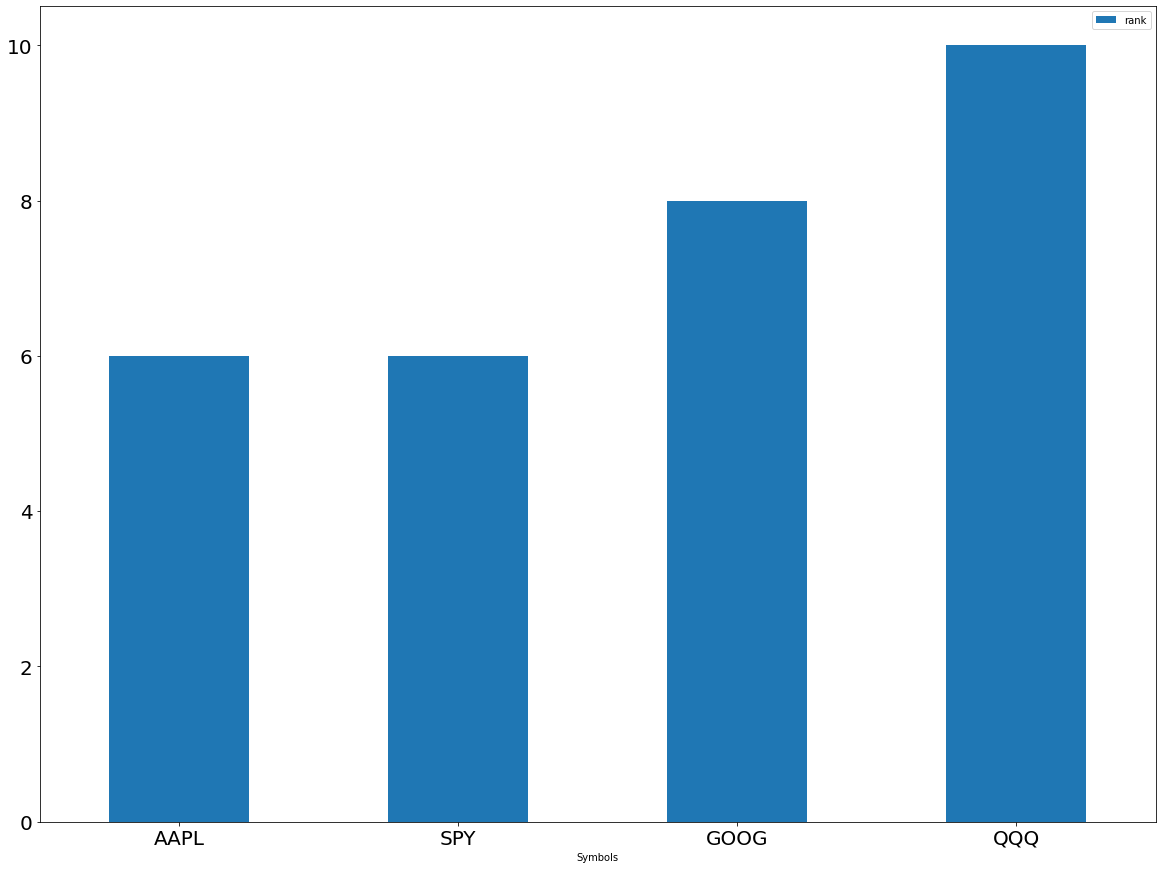

In [29]:
# %%writefile prod.py
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools

# Define variables and inputs:
asset_count=5
ma_short=15
ma_long=50
pv_period=5


myassetlist = input('Assets here, separated by commas: ')
myassetlist = myassetlist.split(',')

use_internal_data = input('Use Internal Data csv file? - reply y/n: ')


if use_internal_data == 'y':
    df = pd.read_csv('data.csv')[myassetlist]
else:
    df = yh(myassetlist)['Close'] # Get close prices
    df.combine_first(pd.read_csv('data.csv', index_col = 'Date', parse_dates=True)).to_csv('data.csv') #update local data source
    

# Get 20 day returns and rank
ranked_momentum = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_momentum.columns = ['20_day_returns']
ranked_momentum['rank'] = ranked_momentum['20_day_returns'].rank()
ranked_momentum

#moving average short/long term
# (short ma - long ma) / long ma
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_assets.columns = ['MA_crossover']
ranked_ma_assets['rank'] = ranked_ma_assets.rank()
ranked_ma_assets

#VPT indicator
# Reference: https://www.investopedia.com/terms/v/vptindicator.asp

vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_assets

ranked_pv_assets.columns = ['VPT_Indicator']
ranked_pv_assets['rank'] = ranked_pv_assets.rank()
ranked_pv_assets

combined = pd.DataFrame(pd.concat([ranked_momentum,ranked_ma_assets,ranked_pv_assets])['rank'])
combined = combined.reset_index()
combined.columns=['Symbols','rank']
combined = combined.groupby('Symbols').sum().sort_values('rank',ascending=False)

print('Results')
print(combined)
combined.sort_values(by='rank').plot.bar(figsize=(20,15), fontsize=20, rot=0)